##  Data Preparation

In [30]:
import pandas as pd
import re
import os
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from community import community_louvain
import plotly.graph_objects as go


In [ ]:
eu_1995 = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'United Kingdom']
eu_2004 = ['Austria', 'Belgium', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
eu_2007 = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
eu_2013 = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']

In [ ]:
# Path to the folder containing the files
folder_path = 'BACI_HS92_V202401b'
df_countries = pd.read_csv('BACI_HS92_V202401b/country_codes_V202401b.csv')
# Initialize an empty list to store DataFrames
dfs = []
# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a DataFrame file (e.g., df_1995.csv)
    if file_name.startswith("BACI_") and file_name.endswith(".csv"):
        # Extract the year from the file name
        year = int(file_name.split("_")[2].split('/')[0][1:])

        
        # Read the file into a DataFrame
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        df = df.rename(columns={'t': 'Year', 'i': 'Exporter', 'j': 'Importer','k': 'Product', 'v': 'Amount', 'q': 'Quantity'})
        #drop product column
        df = df.drop(columns=['Product'])
        
        df = df.merge(df_countries, left_on='Exporter', right_on='country_code', how='left')
        df['Exporter'] = df['country_name']
        df = df.drop(columns=['country_code', 'country_name', 'country_iso2', 'country_iso3'])
        df = df.merge(df_countries, left_on='Importer', right_on='country_code', how='left')
        df['Importer'] = df['country_name']
        df = df.drop(columns=['country_code', 'country_name', 'country_iso2', 'country_iso3'])
        
        df['Total by Exporter'] = df.groupby(['Exporter','Importer'])['Amount'].transform('sum')
        df['Year'] = year
        
        
        print('working with year',year)
        dfs.append(df)
        # Add a new column 'Year' with the year information
        
        # Append the DataFrame to the list


# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df.to_csv("fixed_dataframe.csv", index=False)

In [4]:
df = pd.read_csv('fixed_dataframe.csv')
df

,Year,Exporter,Importer,Total by Exporter
0,2009,Afghanistan,Albania,1.322
1,2009,Afghanistan,Algeria,1204.384
2,2009,Afghanistan,Angola,2190.985
3,2009,Afghanistan,Antigua and Barbuda,0.963
4,2009,Afghanistan,Azerbaijan,22.474
...,...,...,...,...
804671,2019,Zambia,United Kingdom,37423.107
804672,2019,Zambia,United Rep. of Tanzania,64177.580
804673,2019,Zambia,USA,61096.961
804674,2019,Zambia,Burkina Faso,121.421


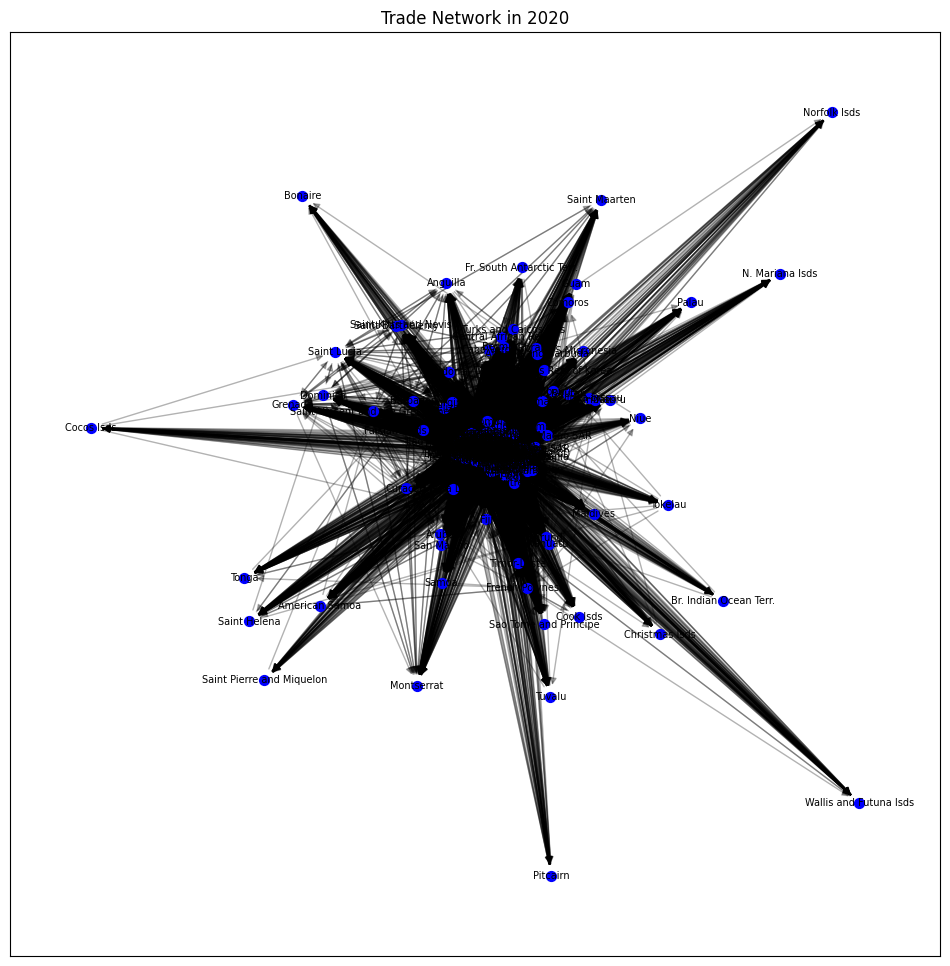

In [7]:
df = pd.read_csv('fixed_dataframe.csv')

# Create a directed graph
G = nx.DiGraph()
df = df[df['Year'] == 2020]
# Add nodes and edges from the data
for _, row in df.iterrows():
    G.add_edge(row['Exporter'], row['Importer'], weight=row['Total by Exporter'])

def draw_network(graph, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15)
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.title(title)
    plt.show()

years = df['Year'].unique()


for year in years:
    G_year = nx.DiGraph()
    df_year = df[df['Year'] == year]
    
    for _, row in df_year.iterrows():
        G_year.add_edge(row['Exporter'], row['Importer'], weight = row['Total by Exporter'])
    
    draw_network(G_year, f'Trade Network in {year}')
    
    



##  Network Reduction
Here we aim at reducing the complexity of the network, trying to keep only relevant links for the economy

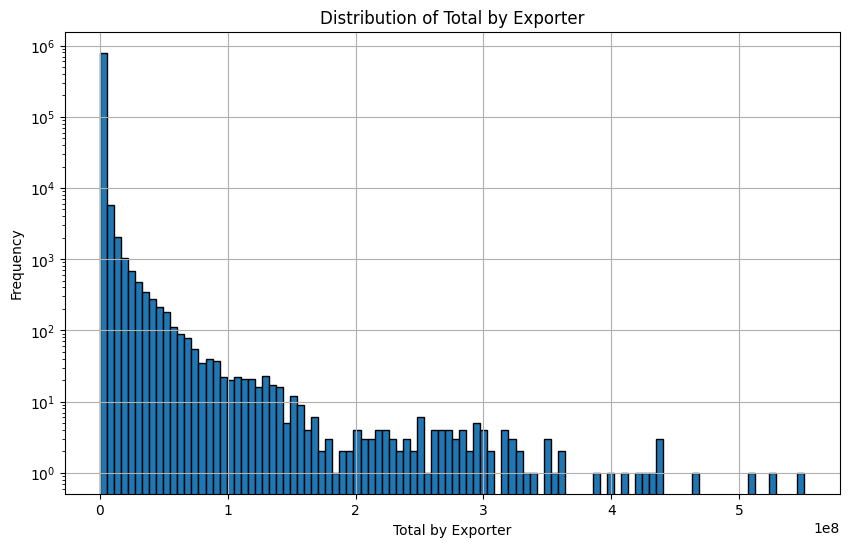

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('fixed_dataframe.csv')

# Plot a histogram of the 'Total by Exporter' values
filtered_df = df[df['Total by Exporter'] > 0]  # Filter out zero values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Total by Exporter'], bins=100, edgecolor='k')
plt.yscale('log')  # Optional: Set the y-axis to a logarithmic scale for better visibility
plt.title('Distribution of Total by Exporter')
plt.xlabel('Total by Exporter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

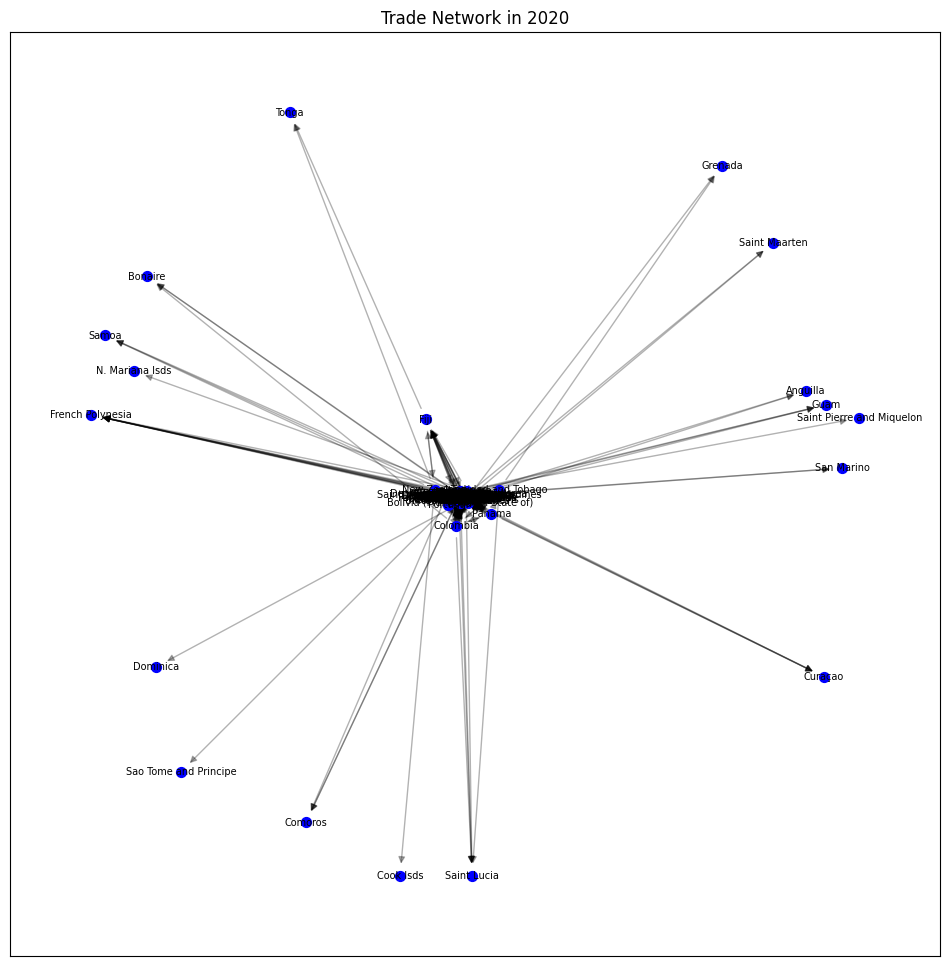

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

eu = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
df = pd.read_csv('fixed_dataframe.csv')
# Create a directed graph
G = nx.DiGraph()
df = df[df['Total by Exporter'] >= 35000]

# Add nodes and edges from the data
for _, row in df.iterrows():
    G.add_edge(row['Exporter'], row['Importer'], weight=row['Total by Exporter'])

def draw_network(graph, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15)
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.title(title)
    plt.show()

years = df['Year'].unique()



G_year = nx.DiGraph()
df_year = df[df['Year'] == 2020]
    
for _, row in df_year.iterrows():
    G_year.add_edge(row['Exporter'], row['Importer'], weight = row['Total by Exporter'])
    
draw_network(G_year, f'Trade Network in 2020')
 



In [13]:
import pandas as pd
import networkx as nx
from scipy.stats import norm, uniform

# Load the dataset
file_path = 'fixed_dataframe.csv'
df = pd.read_csv(file_path)

# Filter the dataset for year 2020
df_2020 = df[df['Year'] == 2020]

# Create the directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in df_2020.iterrows():
    exporter = row['Exporter']
    importer = row['Importer']
    weight = row['Total by Exporter']
    G.add_edge(exporter, importer, weight=weight)


# Convert edges to a dataframe
def local_degree_thresholding(G, k):
    filtered_G = nx.DiGraph()
    for node in G.nodes:
        edges = [(neighbor, G[node][neighbor]['weight']) for neighbor in G.neighbors(node)]
        edges = sorted(edges, key=lambda x: x[1], reverse=True)[:k]
        for neighbor, weight in edges:
            filtered_G.add_edge(node, neighbor, weight=weight)
    return filtered_G

def betweenness_centrality_sparsification(G, top_percentage=0.1):
    edge_betweenness = nx.edge_betweenness_centrality(G, weight='weight')
    num_edges = int(len(edge_betweenness) * top_percentage)
    top_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)[:num_edges]
    filtered_G = nx.DiGraph()
    for (u, v), centrality in top_edges:
        filtered_G.add_edge(u, v, weight=G[u][v]['weight'])
    return filtered_G

def backbone_extraction(G):
    T = nx.minimum_spanning_tree(G.to_undirected(), weight='weight')
    mst_G = nx.DiGraph(T)
    return mst_G

# Convert edges to a dataframe
def edges_to_dataframe(edges):
    edge_list = [(u, v, data['weight']) for u, v, data in edges]
    return pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])

local_thresholded_G = local_degree_thresholding(G, 1)
sparsified_G = betweenness_centrality_sparsification(G, top_percentage=0.5)
backbone_G = backbone_extraction(G)


local_threshold_edges = local_thresholded_G.edges(data=True)
sparsified_edges = sparsified_G.edges(data=True)
backbone_edges = backbone_G.edges(data=True)

# Convert other filtered edges to dataframes and save to CSV
local_threshold_edges_df = edges_to_dataframe(local_threshold_edges)
local_threshold_edges_df.to_csv('local_threshold_edges.csv', index=False)

sparsified_edges_df = edges_to_dataframe(sparsified_edges)
sparsified_edges_df.to_csv('sparsified_edges.csv', index=False)

backbone_edges_df = edges_to_dataframe(backbone_edges)
backbone_edges_df.to_csv('backbone_edges.csv', index=False)

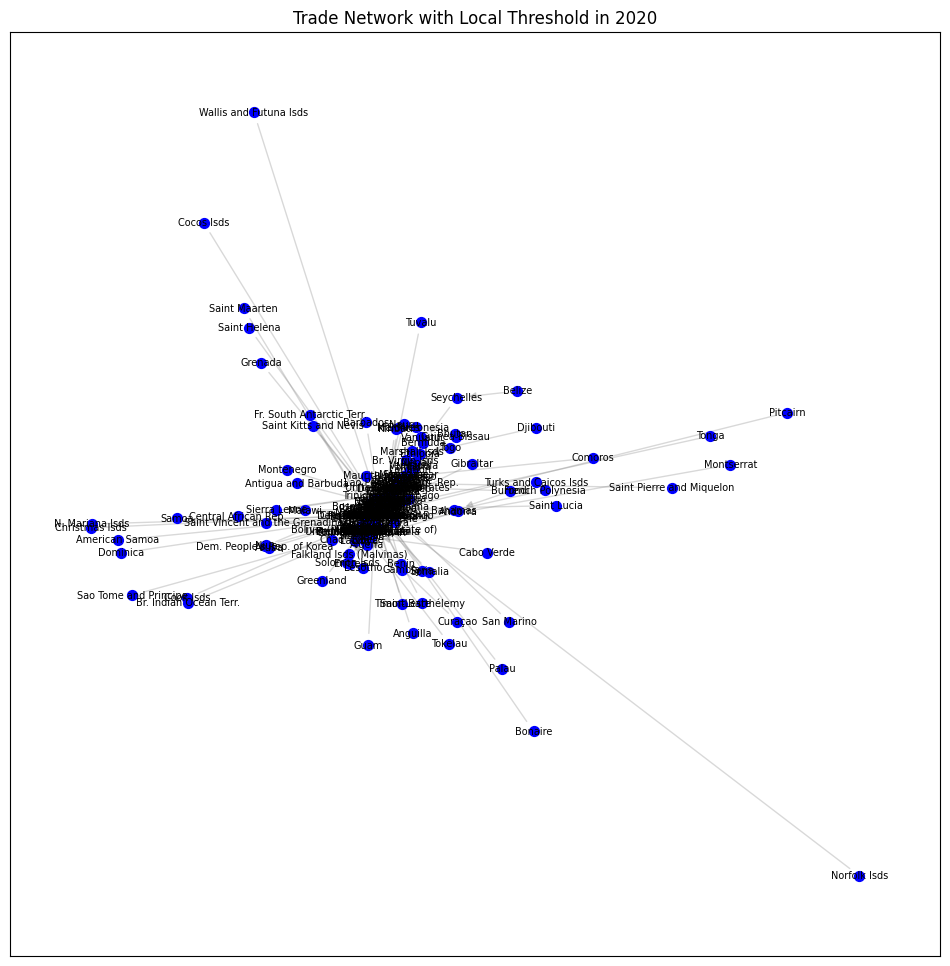

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
df = pd.read_csv('local_threshold_edges.csv')

# Create a directed graph
G = nx.DiGraph()

# Add edges from the data
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Function to draw the network
def draw_network(graph, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15)  # Layout for positioning nodes
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color='grey')
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.title(title)
    plt.show()

# Draw the graph
draw_network(G, 'Trade Network with Local Threshold in 2020')



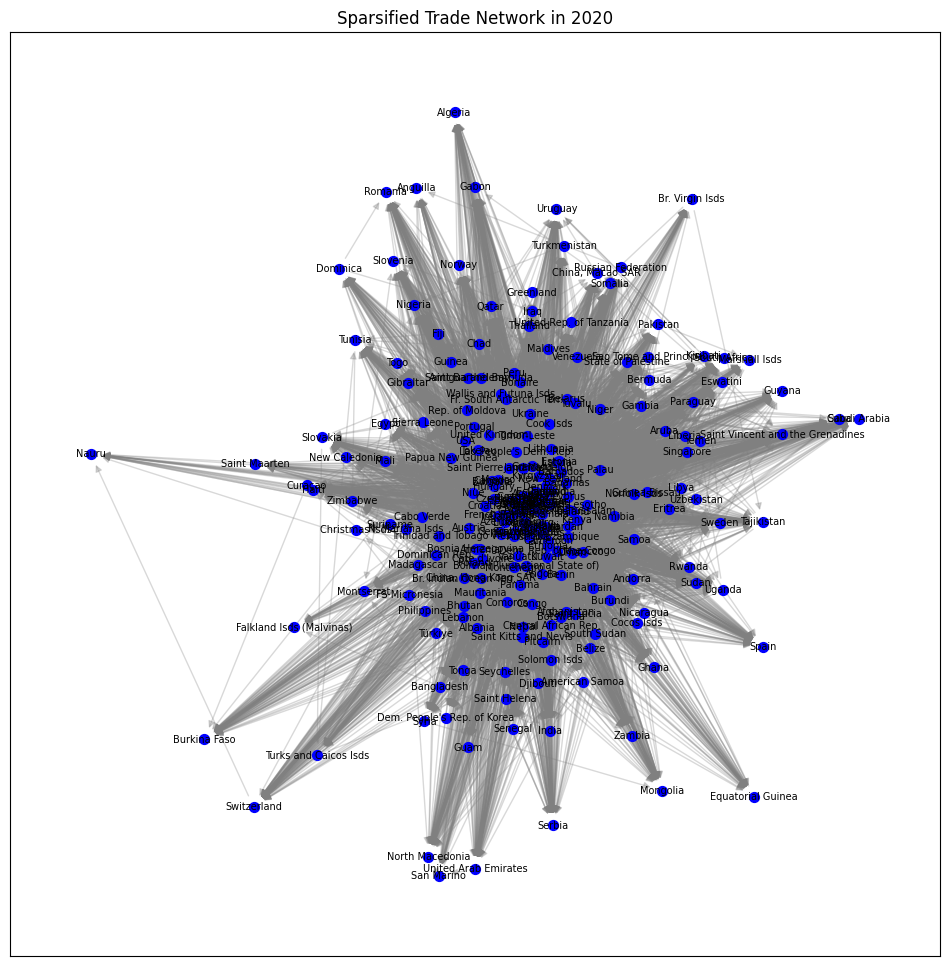

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
df = pd.read_csv('sparsified_edges.csv')

# Create a directed graph
G = nx.DiGraph()

# Add edges from the data
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Function to draw the network
def draw_network(graph, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15)  # Layout for positioning nodes
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3, edge_color='grey')
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.title(title)
    plt.show()

# Draw the graph
draw_network(G, 'Sparsified Trade Network in 2020')




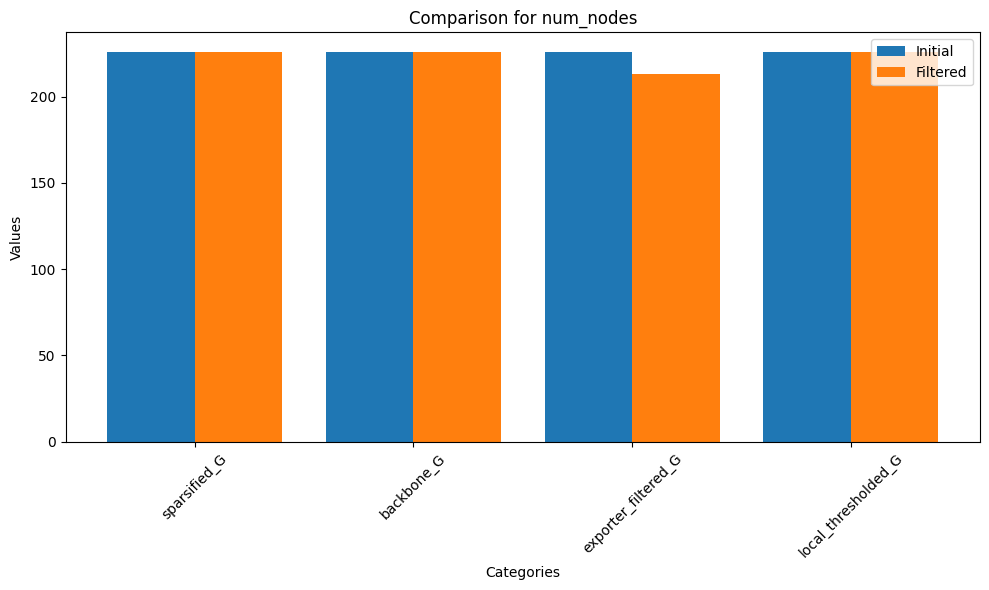

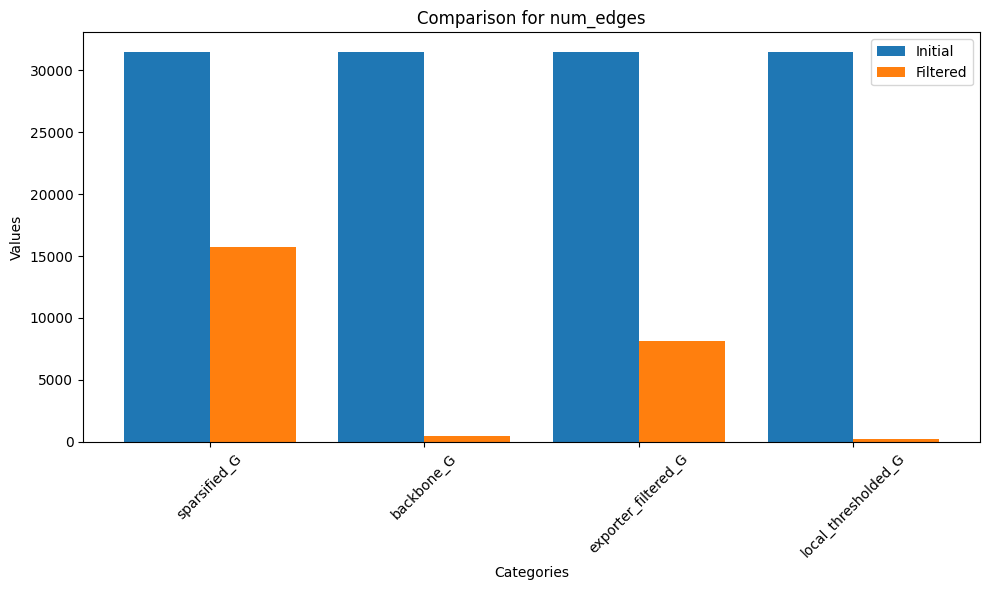

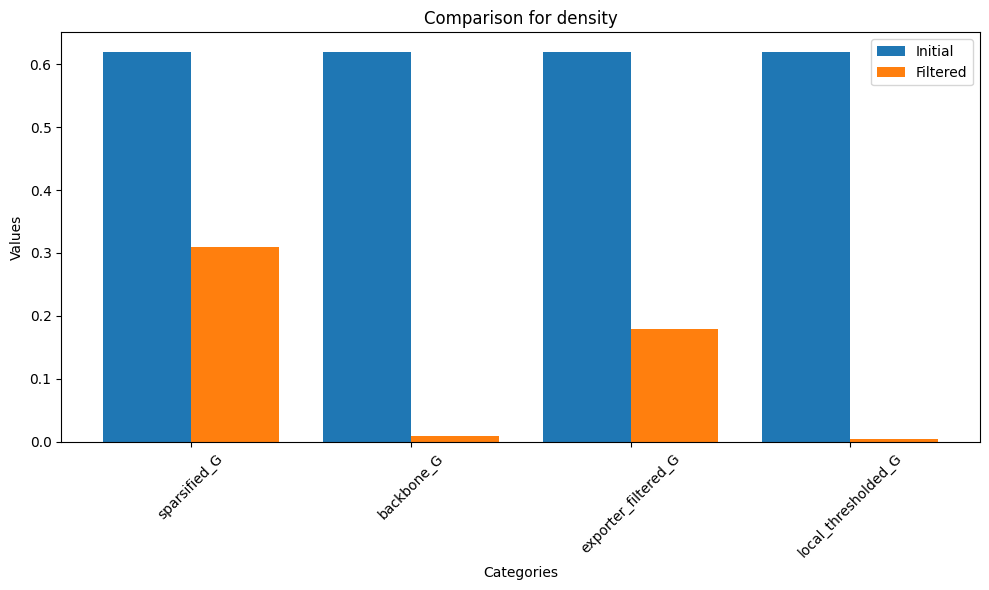

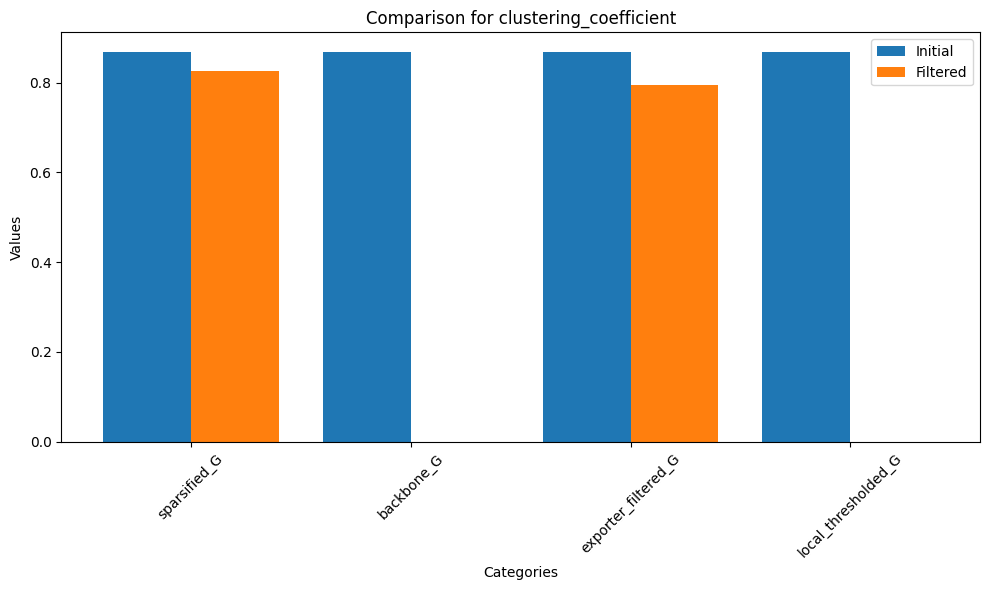

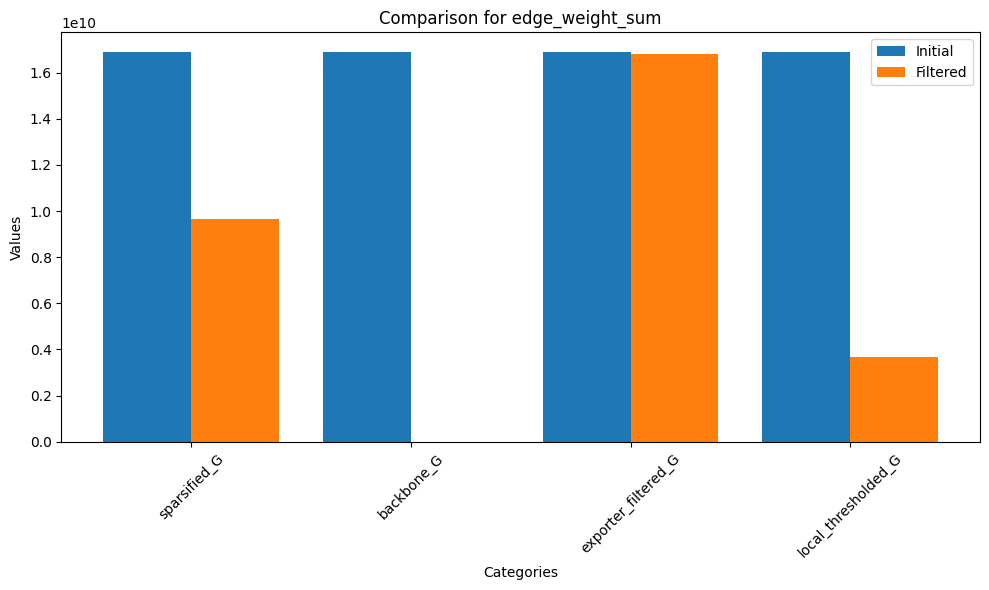

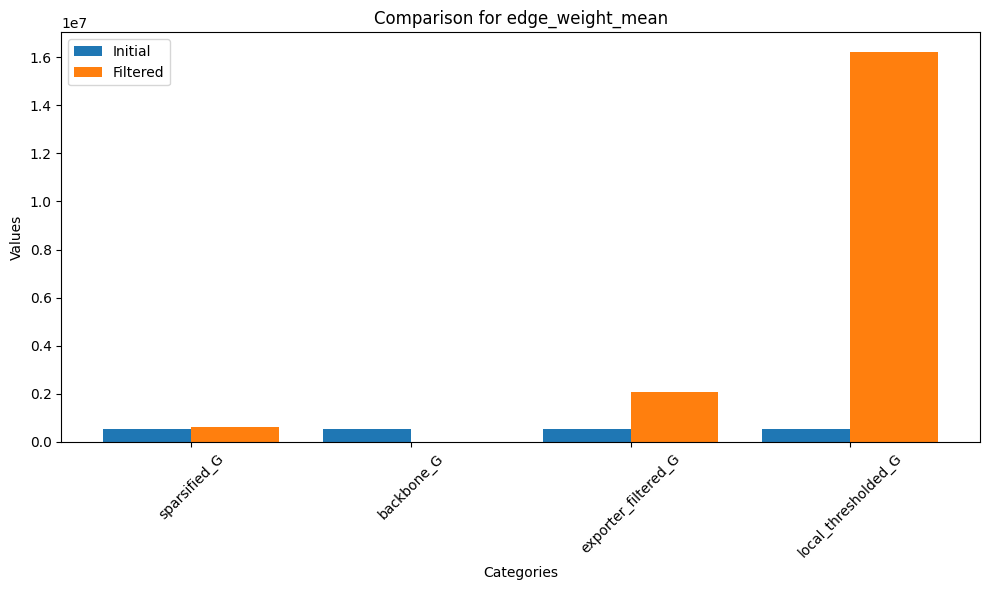

In [17]:
import networkx as nx
import pandas as pd

# Load the dataset
df = pd.read_csv('fixed_dataframe.csv')
df['Weight'] = df['Total by Exporter']
df = df[df['Year']==2020]

# Create the initial graph
G_initial = nx.DiGraph()
for _, row in df.iterrows():
    G_initial.add_edge(row['Importer'], row['Exporter'], weight=row['Weight'])

# Define the function to create filtered graphs
def create_filtered_graphs_initials(G):
    filtered_graphs = {}
    filtered_graphs['local_thresholded_G'] = local_degree_thresholding(G, 1)
    filtered_graphs['sparsified_G'] = betweenness_centrality_sparsification(G, top_percentage=0.5)
    filtered_graphs['backbone_G'] = backbone_extraction(G)
    
    df_filtered = df[df['We'] > 35000]
    G_filtered = nx.DiGraph()
    for _, row in df_filtered.iterrows():
        G_filtered.add_edge(row['Importer'], row['Exporter'], weight=row['Weight'])
    filtered_graphs['exporter_filtered_G'] = G_filtered
    
    
    return filtered_graphs

def create_filtered_graphs(G):
    filtered_graphs = {}
    filtered_graphs['local_thresholded_G'] = local_degree_thresholding(G, 1)
    filtered_graphs['sparsified_G'] = betweenness_centrality_sparsification(G, top_percentage=0.5)
    filtered_graphs['backbone_G'] = backbone_extraction(G)
    
    df_filtered = df[df['Weight'] > 35000]
    G_filtered = nx.DiGraph()
    for _, row in df_filtered.iterrows():
        G_filtered.add_edge(row['Importer'], row['Exporter'], weight=row['Total by Exporter'])
    filtered_graphs['exporter_filtered_G'] = G_filtered
    
    
    return filtered_graphs

# Create filtered graphs
filtered_graphs = create_filtered_graphs(G_initial)

# Function to compute and compare metrics
def compare_graphs(G_initial, filtered_graphs):
    comparisons = {}
    
    def calculate_metrics(G):
        metrics = {}
        metrics['num_nodes'] = G.number_of_nodes()
        metrics['num_edges'] = G.number_of_edges()
        metrics['density'] = nx.density(G)
        metrics['clustering_coefficient'] = nx.average_clustering(G.to_undirected())
        metrics['edge_weight_sum'] = sum([data['weight'] for u, v, data in G.edges(data=True)])
        metrics['edge_weight_mean'] = metrics['edge_weight_sum'] / metrics['num_edges'] if metrics['num_edges'] > 0 else 0
        return metrics

    initial_metrics = calculate_metrics(G_initial)
    for name, G_filtered in filtered_graphs.items():
        filtered_metrics = calculate_metrics(G_filtered)
        comparisons[name] = {
            'num_nodes': (initial_metrics['num_nodes'], filtered_metrics['num_nodes']),
            'num_edges': (initial_metrics['num_edges'], filtered_metrics['num_edges']),
            'density': (initial_metrics['density'], filtered_metrics['density']),
            'clustering_coefficient': (initial_metrics['clustering_coefficient'], filtered_metrics['clustering_coefficient']),
            'edge_weight_sum': (initial_metrics['edge_weight_sum'], filtered_metrics['edge_weight_sum']),
            'edge_weight_mean': (initial_metrics['edge_weight_mean'], filtered_metrics['edge_weight_mean'])
        }
    
    return comparisons

# Compare the initial graph with the filtered graphs
comparisons = compare_graphs(G_initial, filtered_graphs)

import matplotlib.pyplot as plt

# Data from the comparison
categories = ['sparsified_G', 'backbone_G', 'exporter_filtered_G', 'local_thresholded_G']
metrics = ['num_nodes', 'num_edges', 'density', 'clustering_coefficient', 'edge_weight_sum', 'edge_weight_mean']

# Data for each category (initial and filtered)
data = comparisons

# Plotting each metric across categories
for metric in metrics:
    initial_values = [data[category][metric][0] for category in categories]
    filtered_values = [data[category][metric][1] for category in categories]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set bar width
    bar_width = 0.4

    # Set positions for bars
    r1 = range(len(categories))
    r2 = [x + bar_width for x in r1]

    # Plot bars
    ax.bar(r1, initial_values, width=bar_width, label='Initial')
    ax.bar(r2, filtered_values, width=bar_width, label='Filtered')

    # Add labels, title, and legend
    ax.set_xlabel('Categories')
    ax.set_ylabel('Values')
    ax.set_title(f'Comparison for {metric}')
    ax.set_xticks([r + bar_width / 2 for r in r1])
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()



##  Brexit Analysis - With Threshold

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


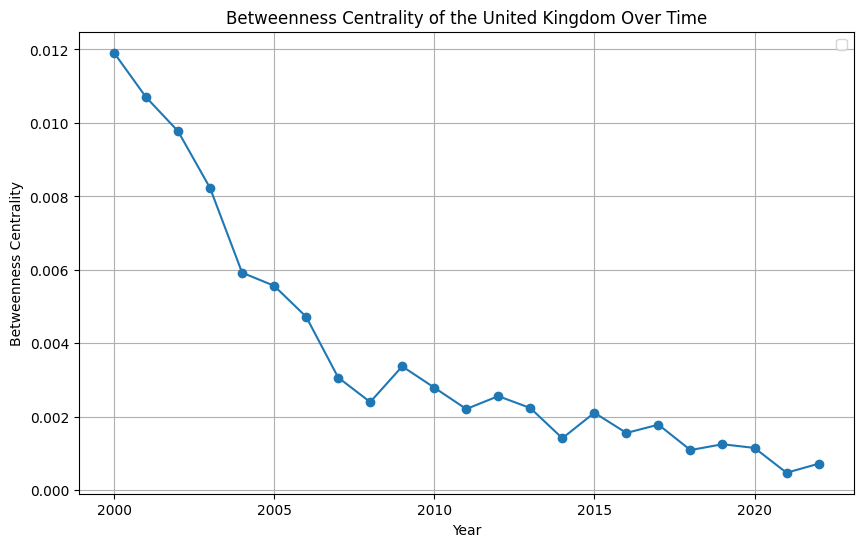

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
df = pd.read_csv('fixed_dataframe.csv')

# Define a minimum threshold for 'Total by Exporter'
min_trade_threshold = 10000  # Adjust this value as needed
df_filtered = df[df['Total by Exporter'] >= min_trade_threshold]

eu = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
df = df_filtered[(df_filtered['Exporter'].isin(eu))&(df_filtered['Importer'].isin(eu))]
##SE CONCATENATE I FILE QUESTO FA TUTTI I NETWORK
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the data
for _, row in df.iterrows():
    G.add_edge(row['Exporter'], row['Importer'], weight=row['Total by Exporter'])

def draw_network(graph, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.15)
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3)
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.title(title)
    plt.show()

years = df['Year'].unique()

betweenness_centralities = {}
degree_centrality = {}
clustering_coefficient = {}
for year in range(2000,2023):
    # Create a subgraph for the specific year
    G_year = nx.DiGraph()
    df_year = df[df['Year'] == year]
    
    for _, row in df_year.iterrows():
        G_year.add_edge(row['Exporter'], row['Importer'], weight = row['Total by Exporter'])
    
    #draw_network(G_year, f'Trade Network in {year}')
    
    betweenness_centralities[year] = nx.betweenness_centrality(G_year, weight = 'weights', normalized = True)
    degree_centrality[year] = nx.degree_centrality(G_year)
    clustering_coefficient[year] = nx.clustering(G_year)
    
import matplotlib.pyplot as plt

# Plot the betweenness centrality of the United Kingdom over time
plt.figure(figsize=(10, 6))
plt.plot(list(betweenness_centralities.keys()), [centrality['United Kingdom'] for centrality in betweenness_centralities.values()], marker='o')
#plt.plot(list(clustering_coefficient.keys()), [centrality['United Kingdom'] for centrality in clustering_coefficient.values()], marker='o')

plt.title('Betweenness Centrality of the United Kingdom Over Time')
plt.xlabel('Year')
plt.ylabel('Betweenness Centrality')
plt.grid(True)
plt.legend()
plt.show()


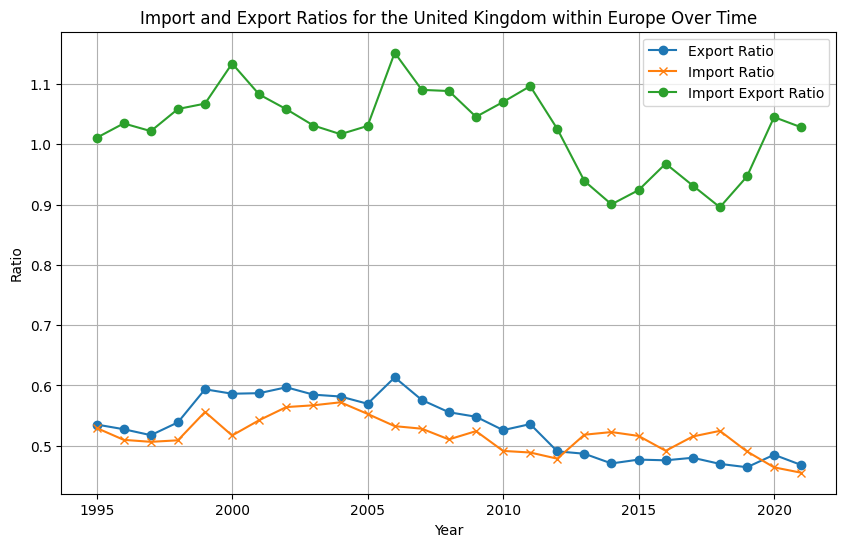

In [20]:
# Define a list of countries considered part of Europe
eu = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
raw_df = pd.read_csv('/Users/lucasoleri/Desktop/Simulation/fixed_dataframe.csv')
raw_df = raw_df[raw_df['Total by Exporter'] >= 35000]

years = raw_df['Year'].unique()

ratio_export = {}
ratio_import ={}
import_europe = {}
export_europe = {}
import_worldwide = {}
export_worldwide = {}

for year in range(1995,2022):
    
    df = raw_df[raw_df['Year'] == year]
    import_within_europe = df[df['Exporter'].isin(eu) & (df['Importer'] == 'United Kingdom')]
    export_within_europe = df[(df['Exporter'] == 'United Kingdom') & df['Importer'].isin(eu)]


    import_world = df[df['Importer'] == 'United Kingdom']
    export_world = df[df['Exporter'] == 'United Kingdom']
    # Calculate the total trade within Europe

    import_within_europe_total = import_within_europe['Total by Exporter'].sum()
    export_within_europe_total = export_within_europe['Total by Exporter'].sum()

    import_world_total = import_world['Total by Exporter'].sum()
    export_world_total = export_world['Total by Exporter'].sum()


    ratio_export[year] = export_within_europe_total/export_world_total
    ratio_import[year] = import_within_europe_total/import_world_total
    
    import_worldwide[year] = import_world_total
    export_worldwide[year] = export_world_total
    
    import_europe[year] = import_within_europe_total
    export_europe[year] = export_within_europe_total



# Plotting
plt.figure(figsize=(10, 6))
x = {}
for year in range(1995,2022):
    x[year] = ratio_export[year]/ratio_import[year]
    
# Plot import and export ratios
plt.plot(list(ratio_export.keys()), list(ratio_export.values()), marker='o', label='Export Ratio')
plt.plot(list(ratio_import.keys()), list(ratio_import.values()), marker='x', label='Import Ratio')
plt.plot(list(x.keys()), list(x.values()), marker='o', label='Import Export Ratio')


plt.title('Import and Export Ratios for the United Kingdom within Europe Over Time')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.grid(True)
plt.legend()
plt.show()

##  Introduction of Euro Analysis

In [23]:
eu_1995 = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden', 'United Kingdom']
eu_1995 = ['Austria', 'Belgium', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain']
eu_2004 = ['Austria', 'Belgium', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
eu_2007 = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']
eu_2013 = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']

In [21]:
raw_df = pd.read_csv('fixed_dataframe.csv', sep=',')
def gen_graph(year):
    df_year = raw_df[raw_df['Year'] == year]
    # Create a subgraph for the specific year
    G_year = nx.DiGraph()
        
    for _, row in df_year.iterrows():
        G_year.add_edge(row['Exporter'], row['Importer'], weight = row['Total by Exporter'])
    return G_year


    
    # for _, row in df.iterrows():
    #     G_year.add_edge(row['Exporter'], row['Importer'], weight=row['Total by Exporter'])

G_1995 = gen_graph(1995)
G_1996 = gen_graph(1996)
G_1997 = gen_graph(1997)
G_1998 = gen_graph(1998)
G_1999 = gen_graph(1999)
G_2000 = gen_graph(2000)
G_2001 = gen_graph(2001)
G_2002 = gen_graph(2002)
G_2003 = gen_graph(2003)
G_2004 = gen_graph(2004)


# # Filter the dataset for year 2020
# df_2020 = df[df['Year'] == 2020]

# # Create the directed graph
# G = nx.DiGraph()

# # Add edges to the graph
# for _, row in df_2020.iterrows():
#     exporter = row['Exporter']
#     importer = row['Importer']
#     weight = row['Total by Exporter']
#     G.add_edge(exporter, importer, weight=weight)



In [24]:
lista = []
for year in range(1995, 2005):
    df = raw_df[raw_df['Year'] == year]
    df_eu_importer = df[df.Importer.isin(eu_2004)]
    df_from_to_eu = df_eu_importer[df_eu_importer.Exporter.isin(eu_1995)]
    from_to_eu = df_eu_importer[df_eu_importer.Exporter.isin(eu_1995)]['Total by Exporter'].sum()
    df_from_out_to_eu = df_eu_importer[~df_eu_importer.Exporter.isin(eu_1995)]
    from_out_to_eu = df_eu_importer[~df_eu_importer.Exporter.isin(eu_1995)]['Total by Exporter'].sum()
    df_eu_exporter = df[df.Exporter.isin(eu_1995)]
    df_from_eu_to_out = df_eu_exporter[~df_eu_exporter.Importer.isin(eu_1995)]
    from_eu_to_out = df_eu_exporter[~df_eu_exporter.Importer.isin(eu_1995)]['Total by Exporter'].sum()
    proportion_exports = from_to_eu/(from_eu_to_out + from_to_eu)
    proportion_imports = from_to_eu/(from_out_to_eu + from_to_eu)
    lista.append([proportion_exports, proportion_imports])


[0.5148007960975259, 0.5082218157449377, 0.5000787084037639, 0.5100246756682424, 0.5780394722874563, 0.5634817324271691, 0.5595823432044856, 0.5573619761682705, 0.5611528595631858, 0.5611608942346022]
[0.4613467775469971, 0.45481728823143863, 0.4455679788993931, 0.45065981024657237, 0.5164767323092669, 0.4850725349950857, 0.4971764066087592, 0.5061906907662322, 0.5084405672398511, 0.5036011332366557]


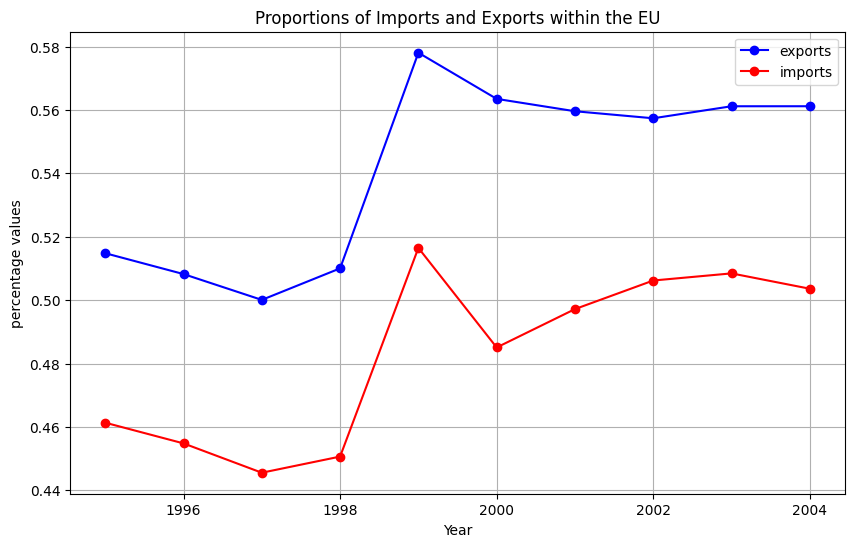

In [25]:
import matplotlib.pyplot as plt



# Extract x and y values from the data
x = [point[0] for point in lista]
y = [point[1] for point in lista]
print(x)
print(y)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1995, 2005), x, marker='o', linestyle='-', color='b', label='exports')
plt.plot(range(1995, 2005), y, marker='o', linestyle='-', color='r', label='imports')
# Adding title and labels
plt.title('Proportions of Imports and Exports within the EU')
plt.xlabel('Year')
plt.ylabel('percentage values')
plt.legend()
# Display the plot
plt.grid(True)
plt.show()


In [26]:
def calculate_node_strengths(G, cluster):
    subgraph = G.subgraph(cluster)
    strengths = {node: sum(data['weight'] for _, _, data in subgraph.edges(node, data=True)) for node in subgraph.nodes()}
    return strengths

def weighted_network_centralization(strengths):
    max_strength = max(strengths.values())
    centralization = sum(max_strength - s for s in strengths.values())
    max_possible_centralization = (len(strengths) - 1) * max_strength
    return centralization / max_possible_centralization if max_possible_centralization != 0 else 0



# Calculate node strengths for the EU cluster
strengths_EU_1995 = calculate_node_strengths(G_1995, eu_1995)
strengths_EU_1996 = calculate_node_strengths(G_1996, eu_1995)
strengths_EU_1997 = calculate_node_strengths(G_1997, eu_1995)
strengths_EU_1998 = calculate_node_strengths(G_1998, eu_1995)
strengths_EU_1999 = calculate_node_strengths(G_1999, eu_1995)
strengths_EU_2000 = calculate_node_strengths(G_2000, eu_1995)
strengths_EU_2001 = calculate_node_strengths(G_2001, eu_1995)
strengths_EU_2002 = calculate_node_strengths(G_2002, eu_1995)
strengths_EU_2003 = calculate_node_strengths(G_2003, eu_1995)
strengths_EU_2004 = calculate_node_strengths(G_2004, eu_1995)

# Calculate weighted network centralization for the EU cluster
centralization_EU_1995 = weighted_network_centralization(strengths_EU_1995)
centralization_EU_1996 = weighted_network_centralization(strengths_EU_1996)
centralization_EU_1997 = weighted_network_centralization(strengths_EU_1997)
centralization_EU_1998 = weighted_network_centralization(strengths_EU_1998)
centralization_EU_1999 = weighted_network_centralization(strengths_EU_1999)
centralization_EU_2000 = weighted_network_centralization(strengths_EU_2000)
centralization_EU_2001 = weighted_network_centralization(strengths_EU_2001)
centralization_EU_2002 = weighted_network_centralization(strengths_EU_2002)
centralization_EU_2003 = weighted_network_centralization(strengths_EU_2003)
centralization_EU_2004 = weighted_network_centralization(strengths_EU_2004)

# Compare centralization scores
print("Weighted Network Centralization for EU 1995:", centralization_EU_1995)
print("Weighted Network Centralization for EU 1996:", centralization_EU_1996)
print("Weighted Network Centralization for EU 1997:", centralization_EU_1997)
print("Weighted Network Centralization for EU 1998:", centralization_EU_1998)
print("Weighted Network Centralization for EU 1999:", centralization_EU_1999)
print("Weighted Network Centralization for EU 2000:", centralization_EU_2000)
print("Weighted Network Centralization for EU 2001:", centralization_EU_2001)
print("Weighted Network Centralization for EU 2002:", centralization_EU_2002)
print("Weighted Network Centralization for EU 2003:", centralization_EU_2003)
print("Weighted Network Centralization for EU 2004:", centralization_EU_2004)


Weighted Network Centralization for EU 1995: 0.7438622996699987
Weighted Network Centralization for EU 1996: 0.7340872953590715
Weighted Network Centralization for EU 1997: 0.7261805658131435
Weighted Network Centralization for EU 1998: 0.7396198811334748
Weighted Network Centralization for EU 1999: 0.746320702921787
Weighted Network Centralization for EU 2000: 0.7362305867073613
Weighted Network Centralization for EU 2001: 0.7537891292159337
Weighted Network Centralization for EU 2002: 0.7521449594104522
Weighted Network Centralization for EU 2003: 0.7437263628457776
Weighted Network Centralization for EU 2004: 0.7546606724261192


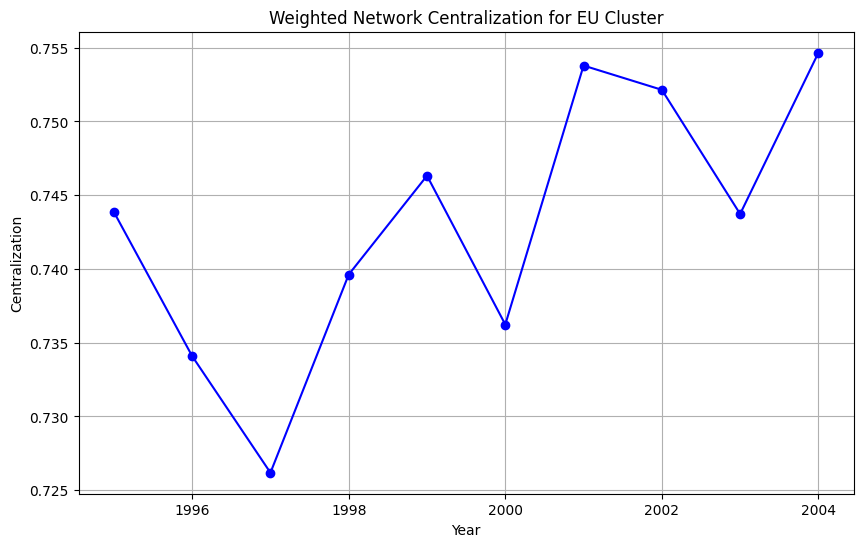

In [27]:
# Define the years and centralization values

years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]

centralization_values = [centralization_EU_1995,
                            centralization_EU_1996,
                            centralization_EU_1997, 
                            centralization_EU_1998, 
                            centralization_EU_1999, 
                            centralization_EU_2000, 
                            centralization_EU_2001, 
                            centralization_EU_2002, 
                            centralization_EU_2003, 
                            centralization_EU_2004]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, centralization_values, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Weighted Network Centralization for EU Cluster')
plt.xlabel('Year')
plt.ylabel('Centralization')

# Display the plot
plt.grid(True)
plt.show()

##  Community Detection

In [33]:
df = pd.read_csv("fixed_dataframe.csv")
df = df[df['Total by Exporter'] > 35000]
years = list(df["Year"].unique())
years.sort()

def html_creator(filtered_df, year, min_trade_threshold = 35000):
    # Function to calculate modularity
    def calculate_modularity(G, partition):
        return community_louvain.modularity(partition, G)
    
    # Function to calculate community size distribution
    def community_size_distribution(partition):
        communities = {}
        for node, community in partition.items():
            if community not in communities:
                communities[community] = 0
            communities[community] += 1
        sizes = list(communities.values())
        return sizes
    
    
    # Function to calculate conductance
    def calculate_conductance(G, partition):
        conductance = {}
        for community in set(partition.values()):
            internal_edges = 0
            external_edges = 0
            nodes = [node for node in partition if partition[node] == community]
            for node in nodes:
                for neighbor in G.neighbors(node):
                    if partition[neighbor] == community:
                        internal_edges += 1
                    else:
                        external_edges += 1
            internal_edges //= 2  # Each internal edge is counted twice
            conductance[community] = external_edges / (2 * internal_edges + external_edges)
        return conductance
    
    # Function to calculate average internal and external degrees
    def calculate_degrees(G, partition):
        internal_degrees = {}
        external_degrees = {}
        for community in set(partition.values()):
            nodes = [node for node in partition if partition[node] == community]
            internal_sum = 0
            external_sum = 0
            for node in nodes:
                for neighbor in G.neighbors(node):
                    if partition[neighbor] == community:
                        internal_sum += 1
                    else:
                        external_sum += 1
            internal_degrees[community] = internal_sum / len(nodes)
            external_degrees[community] = external_sum / len(nodes)
        return internal_degrees, external_degrees
    
    
    
    filtered_df = filtered_df[filtered_df["Year"] == year].reset_index()

    df_positions = pd.read_csv('FIN_countries_centroids.csv', sep=',')
    df_continents = pd.read_csv('FIN_countries_continents.csv', sep=',')
    
    # Create dictionaries for positions and continents
    d_positions = df_positions.set_index('Country')[['Longitude', 'Latitude']].T.to_dict('list')
    d_continents = df_continents.set_index('Country')['Continent'].to_dict()
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes and edges
    for _, row in filtered_df.iterrows():
        exporter = row['Exporter']
        importer = row['Importer']
        amount = row['Total by Exporter']
        if exporter in d_positions and importer in d_positions:
            G.add_node(exporter, pos=d_positions[exporter])
            G.add_node(importer, pos=d_positions[importer])
            G.add_edge(exporter, importer, weight=amount)
    
    # Perform community detection using the Louvain method
    partition = community_louvain.best_partition(G)
    
    # Assign a color to each community
    colors = [partition[node] for node in G.nodes()]
    
    # Extract positions
    pos_2d = nx.get_node_attributes(G, 'pos')
    
    # Extract node and edge positions
    node_lons = [pos_2d[node][0] for node in G.nodes()]
    node_lats = [pos_2d[node][1] for node in G.nodes()]
    edge_lons = []
    edge_lats = []
    for edge in G.edges():
        edge_lons += [pos_2d[edge[0]][0], pos_2d[edge[1]][0], None]
        edge_lats += [pos_2d[edge[0]][1], pos_2d[edge[1]][1], None]
    
    # Create the network graph with a map background
    fig = go.Figure()
    
    
    # Add nodes to the plot
    fig.add_trace(go.Scattergeo(
        lon=node_lons,
        lat=node_lats,
        mode='markers',
        text=list(G.nodes),
        hoverinfo='text',
        marker=dict(symbol='circle', size=6, color=colors, colorscale='Viridis')
    ))
    
    # Create a list of unique community identifiers
    unique_communities = sorted(set(partition.values()))
    
    legend_data = []
    for community_id in unique_communities:
        legend_data.append(go.Scattergeo(
            lon=[],
            lat=[],
            mode='markers',
            name=f'Community {community_id}',
            marker=dict(symbol='circle', size=6, color=community_id, colorscale='Viridis'),
            showlegend=True
        ))
    
    # Add legend data to the figure
    for data in legend_data:
        fig.add_trace(data)
    
    # Update the layout for the map
    fig.update_layout(
        title=f'Community Network Year {year}, with minimum trade threshold of {min_trade_threshold}',
        geo=dict(
            projection_type='natural earth',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            subunitcolor='rgb(217, 217, 217)',
            countrycolor='rgb(217, 217, 217)',
            showcountries=True,
        ),
        showlegend=False
    )
    
    modularity = calculate_modularity(G, partition)
    community_sizes = community_size_distribution(partition)
    conductance = calculate_conductance(G, partition)
    internal_degrees, external_degrees = calculate_degrees(G, partition)
    
    output = {"modularity": modularity,
              "community_sizes": community_sizes}
    
    
    
    # Save the plot as an HTML file
    fig.write_html(f'/Users/lucasoleri/Desktop/Simulation/Networks/Community Networks/2dcommunity_network_with_map{year}.html')

    return output
    
tuttioutput = []
for i in years:
    output = html_creator(df, i)
    tuttioutput.append(output)
    

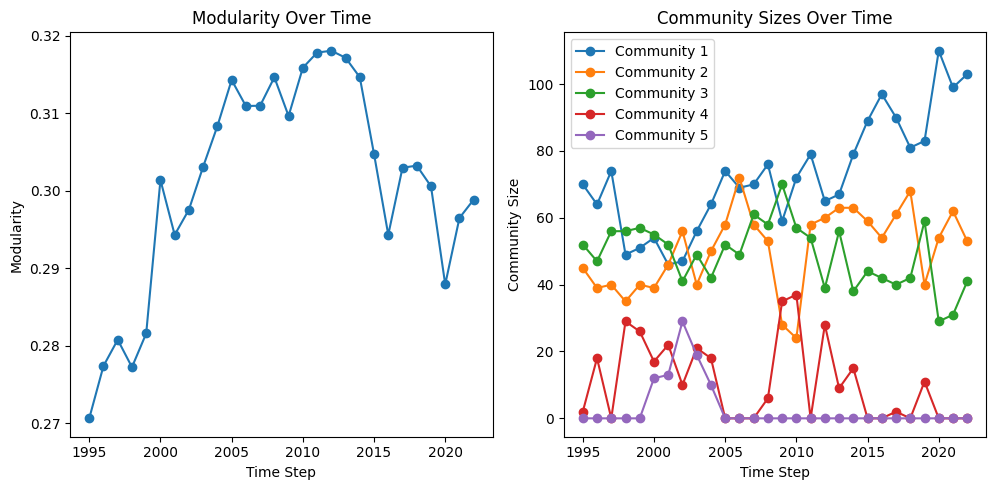

In [34]:
import numpy as np

def plot_trade_metrics(data):
    # Extracting data for plotting
    modularity = [entry['modularity'] for entry in data]
    community_sizes = [entry['community_sizes'] for entry in data]
    
    # Prepare for community sizes plot
    max_communities = max(len(sizes) for sizes in community_sizes)
    community_sizes_padded = [sizes + [0] * (max_communities - len(sizes)) for sizes in community_sizes]

    # Prepare x-axis values (assuming data is from 1995 to 2022)
    years = np.arange(1995, 2023)  # Generates an array from 1995 to 2022 (inclusive)

    # Plotting modularity
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(years, modularity, marker='o')
    plt.title('Modularity Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Modularity')
    
    # Plotting community sizes
    plt.subplot(1, 3, 2)
    for i in range(max_communities):
        sizes = [size[i] if i < len(size) else 0 for size in community_sizes]
        plt.plot(years, sizes, marker='o', label=f'Community {i+1}')
    plt.title('Community Sizes Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Community Size')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
plot_trade_metrics(tuttioutput)